In [1]:
import seaborn as sns
import os
import sys
import numpy as np
import random

module_path = os.path.abspath(os.path.join('../../'))
if module_path not in sys.path:
    sys.path.append(module_path)

from experiments.result_buckets import human_results
from experiments.bucket_analysis import BucketDatasetResult

%load_ext autoreload
%autoreload 2

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 250/250 [00:00<00:00, 30884.07it/s]


### Main Consistency Section (Section 5)

In [ ]:
## section 5 table 3

for dataset in ['snli', 'atomic', 'social', 'anli']:
    bucket_preds = human_results['roberta'][f'{dataset}-human']
    test_preds = human_results['roberta'][f'{dataset}-test']

    print(green(dataset))

    print('P(FLIP):', bucket_preds.calculate_p_flip(test_preds)['flip_prob'])
    print('P(FLIP)-corrected:', bucket_preds.calculate_p_flip(test_preds)['flip_prob_corrected'])
    print('P(FLIP) sanity check:', 2 * bucket_preds.law_of_total_variance_breakdown()['unexplained_variance'])
    print()
    print('P(STAY):', bucket_preds.calculate_p_stay(test_preds)['stay_prob'])
    print('P(STAY)-corrected:', bucket_preds.calculate_p_stay(test_preds)['stay_prob_corrected'])
    print('P(STAY) sanity check:', 1 - bucket_preds.calculate_p_flip(test_preds)['flip_prob'], 'P(STAY)-corrected sanity check:', 1-bucket_preds.calculate_p_flip(test_preds)['flip_prob_corrected'])
    print()
    print('C:', bucket_preds.mean_unweighted_consistency)
    print('C-corrected:', bucket_preds.calculate_weighted_consistency(test_preds))
    print()
    print('POVE:', bucket_preds.law_of_total_variance_breakdown()['POVE'])
    print('POVE-corrected:', bucket_preds.calculate_weighted_proportion_explained(test_preds))
    print("------------------------------------")

bow
P(STAY): 0.8218721982867218
P(STAY)-corrected: 0.809207172862765

test set acc: 0.5574305933587371
paranlu acc: 0.58
paraphrase acc: 0.5368686868686868
paraphrase acc corrected: 0.5255021426626035

bilstm
P(STAY): 0.732366187956664
P(STAY)-corrected: 0.7415121224625836

test set acc: 0.6804572672836146
paranlu acc: 0.62
paraphrase acc: 0.5762626262626263
paraphrase acc corrected: 0.6038732935236668

roberta
P(STAY): 0.748339962207105
P(STAY)-corrected: 0.9009562634337458

test set acc: 0.8671747414262384
paranlu acc: 0.512
paraphrase acc: 0.5383838383838384
paraphrase acc corrected: 0.8459684445350615

deberta_v3
P(STAY): 0.8282888145628627
P(STAY)-corrected: 0.8407364882759276

test set acc: 0.9123571039738705
paranlu acc: 0.768
paraphrase acc: 0.7035353535353536
paraphrase acc corrected: 0.8054035293998881

unified_roberta
P(STAY): 0.7799316187956662
P(STAY)-corrected: 0.8858536649568565

test set acc: 0.8568317909635275
paranlu acc: 0.66
paraphrase acc: 0.5994949494949495
paraph

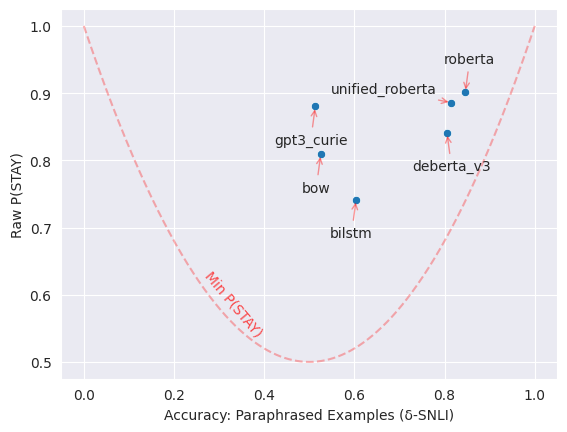

In [7]:
from simple_colors import *
sns.set_style('darkgrid')
import matplotlib.pyplot as plt
from adjustText import adjust_text  # Import adjust_text function

x = []
y = []
names = []

for model, results in human_results.items():
    analysis = results['snli-human']
    test_results = results['snli-test']

    linguistic_robustness = analysis.linguistic_robustness_summary(test_results)
    
    print(green(model))
    #print(linguistic_robustness)

    print('P(STAY):', linguistic_robustness['stay_prob'])
    print('P(STAY)-corrected:', linguistic_robustness['stay_prob_corrected'])
    print('\ntest set acc:', test_results.accuracy)
    print('paranlu acc:', analysis.original_example_accuracy())
    print('paraphrase acc:', analysis.paraphrase_accuracy())
    print('paraphrase acc corrected:', analysis.calculate_weighted_paraphrase_accuracy(test_results))
    
    x.append(analysis.calculate_weighted_paraphrase_accuracy(test_results)) #) # 
    y.append(linguistic_robustness['stay_prob_corrected'])
    names.append(model)
    print()

sns.scatterplot(x=x, y=y)

ax = plt.gca()
ax.set_xlabel("Accuracy: Paraphrased Examples (δ-SNLI)")
ax.set_ylabel("Raw P(STAY)")

for i in range(len(names)):
    arrow_properties = dict(arrowstyle='->', connectionstyle='arc3', color='red', alpha=0.4)
    if names[i] in ['gpt3_curie', 'bow', 'bilstm']:
        positioning = (x[i] - 0.01, y[i] - 0.05)
    elif names[i] == 'unified_roberta':
        positioning = (x[i] - 0.15, y[i] + 0.02)
    elif names[i] == 'deberta_v3':
        positioning = (x[i] + 0.01, y[i] - 0.05)
    else:
        positioning = (x[i] + 0.01, y[i] + 0.05)

    plt.annotate(names[i], xy=(x[i], y[i]), xytext=positioning, arrowprops=arrow_properties, fontsize=10, ha='center', va='center',)



# plot the bowl
bernoullis = np.linspace(0, 1, 1000)
bernoulli_vars = bernoullis * (1-bernoullis)
min_pstay = 1 - 2*bernoulli_vars

ax.plot(bernoullis, min_pstay, 'r--', label='Min P(STAY)', alpha=0.3)
ax.annotate("Min P(STAY)", (bernoullis[400], min_pstay[400]+0.12), rotation=-50, ha='right', va='top', alpha=0.7, color='red')

plt.savefig('modeling_paradigms_pstay.pdf')
plt.show()


In [ ]:
import plotly.express as px

# This plot shows that the there is positive correlation between how extreme the confidence is and discrete consistency.

model = human_results['roberta']['snli-human']

x = [b.original_example_prediction.confidence_deviation for b in model.buckets]
y = [b.bucket_discrete_agreement for b in model.buckets]

fig = px.scatter(x=x, y=y, labels={'x': 'deviation', 'y': 'discrete_agreement'}, trendline="ols")

fig.show()